# QM9 

Installation of necessary dependencies

In [1]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda:0


In [2]:
# # Install torch geometric
# %pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
# %pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
# %pip install torch-geometric
# %pip install -q git+https://github.com/snap-stanford/deepsnap.git
# %pip install wget

Download QM9 dataset

make dataloader

In [3]:
from typing import Optional, Callable, List

import sys
import os
import os.path as osp
from tqdm import tqdm
import numpy as np

import torch
import torch.nn.functional as F
from torch_scatter import scatter
from torch_geometric.data import (InMemoryDataset, download_url, extract_zip,
                                  Data)
from torch_geometric.nn import radius_graph
from e3nn.o3 import Irreps, spherical_harmonics

from torch_geometric.nn import TransformerConv

In [4]:
HAR2EV = 27.211386246
KCALMOL2EV = 0.04336414

conversion = torch.tensor([
    1., 1., HAR2EV, HAR2EV, HAR2EV, 1., HAR2EV, HAR2EV, HAR2EV, HAR2EV, HAR2EV,
    1., KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, 1., 1., 1.
])

atomrefs = {
    6: [0., 0., 0., 0., 0.],
    7: [
        -13.61312172, -1029.86312267, -1485.30251237, -2042.61123593,
        -2713.48485589
    ],
    8: [
        -13.5745904, -1029.82456413, -1485.26398105, -2042.5727046,
        -2713.44632457
    ],
    9: [
        -13.54887564, -1029.79887659, -1485.2382935, -2042.54701705,
        -2713.42063702
    ],
    10: [
        -13.90303183, -1030.25891228, -1485.71166277, -2043.01812778,
        -2713.88796536
    ],
    11: [0., 0., 0., 0., 0.],
}


targets = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0',
           'U', 'H', 'G', 'Cv', 'U0_atom', 'U_atom', 'H_atom', 'G_atom', 'A', 'B', 'C']

tid = targets.index("alpha")


### Model run parameters

In [5]:
epochs =10
batch_size=128
lr = 5e-4 #learning rate
weight_decay=1e-8
num_workers =4 #num workers in dataloader
save_dir = "saved models" #directory to save models

#set the task variable
task="graph"

#set the logging flag
log = True

### Dataset parameters

In [6]:
dataset = "qm9"
root = "datasets" #dataset location
target = "alpha" 
radius = 2 #Radius (Angstrom) between which atoms to add links.
feature_type = "one_hot"

### Model parameters

In [7]:
model ="segnn"
hidden_features= 32 #number of hidden features
lmax_h =2 #max degree of hidden rep
lmax_attr=3 #max degree of geometric attribute embedding
subspace_type = "weightbalanced" #how to divide spherical harmonic subspace
layers = 3 #number of message passing layers
norm = "instance" #normalisation type
pool = "avg"
conv_type = "linear" #linear or non-linear aggregation of local information in SEConv

In [8]:
class TargetGetter(object):
    """ Gets relevant target """

    def __init__(self, target):
        self.target = target
        self.target_idx = targets.index(target)

    def __call__(self, data):
        # Specify target.
        data.y = data.y[0, self.target_idx]
        return data

In [9]:
class QM9(InMemoryDataset):
    
    r"""The QM9 dataset from the `"MoleculeNet: A Benchmark for Molecular
    Machine Learning" <https://arxiv.org/abs/1703.00564>`_ paper, consisting of
    about 130,000 molecules with 19 regression targets.
    Each molecule includes complete spatial information for the single low
    energy conformation of the atoms in the molecule.
    In addition, we provide the atom features from the `"Neural Message
    Passing for Quantum Chemistry" <https://arxiv.org/abs/1704.01212>`_ paper. """

    raw_url = ('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/'
               'molnet_publish/qm9.zip')
    raw_url2 = 'https://ndownloader.figshare.com/files/3195404'
    processed_url = 'https://data.pyg.org/datasets/qm9_v3.zip'

    def __init__(self, root, target, radius, partition, lmax_attr, feature_type):
        # assert feature_type in ["one_hot", "cormorant", "gilmer"], "Please use valid features"
        # assert target in targets
        # assert partition in ["train", "valid", "test"]
        self.root = osp.abspath(osp.join(root, "qm9"))
        self.target = target
        self.radius = radius
        self.partition = partition
        self.feature_type = feature_type
        self.lmax_attr = lmax_attr
        self.attr_irreps = Irreps.spherical_harmonics(lmax_attr)
        transform = TargetGetter(self.target)

        super().__init__(self.root, transform)

        self.data, self.slices = torch.load(self.processed_paths[0])

    def calc_stats(self):
        ys = np.array([data.y.item() for data in self])
        mean = np.mean(ys)
        mad = np.mean(np.abs(ys - mean))
        return mean, mad

    def atomref(self, target) -> Optional[torch.Tensor]:
        if target in atomrefs:
            out = torch.zeros(100)
            out[torch.tensor([1, 6, 7, 8, 9])] = torch.tensor(atomrefs[target])
            return out.view(-1, 1)
        return None
    
    @ property
    def raw_file_names(self) -> List[str]:
        try:
            import rdkit  # noqa
            return ['gdb9.sdf', 'gdb9.sdf.csv', 'uncharacterized.txt']
        except ImportError:
            print("Please install rdkit")
            return
        
    @ property
    def processed_file_names(self) -> str:
        return ["_".join([self.partition, "r="+str(np.round(self.radius, 2)),
                          self.feature_type, "l="+str(self.lmax_attr)]) + '.pt']
    
    def download(self):
        print("Downloading to", self.raw_dir, self.raw_url)
        try:
            import rdkit  # noqa
            file_path = download_url(self.raw_url, self.raw_dir)
            extract_zip(file_path, self.raw_dir)
            os.unlink(file_path)

            file_path = download_url(self.raw_url2, self.raw_dir)
            os.rename(osp.join(self.raw_dir, '3195404'),
                      osp.join(self.raw_dir, 'uncharacterized.txt'))
        except ImportError:
            path = download_url(self.processed_url, self.raw_dir)
            extract_zip(path, self.raw_dir)
            os.unlink(path)

    '''This code defines the process() method of a PyTorch dataset class. 
    The purpose of this method is to process the raw data of the dataset into a format 
    that can be used for training a machine learning model.'''

    def process(self):
        try:
            import rdkit
            from rdkit import Chem
            from rdkit.Chem.rdchem import HybridizationType
            from rdkit.Chem.rdchem import BondType as BT
            from rdkit import RDLogger
            RDLogger.DisableLog('rdApp.*')
        except ImportError:
            print("Please install rdkit")
            return

        print("Processing data for", self.partition, "set with radius=" + str(np.round(self.radius, 2)) +
              ",", "l_attr=" + str(self.lmax_attr), "and", self.feature_type, "features.")
        types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}

        with open(self.raw_paths[1], 'r') as f:
            target = f.read().split('\n')[1:-1]
            target = [[float(x) for x in line.split(',')[1:20]]
                      for line in target]
            target = torch.tensor(target, dtype=torch.float)
            target = torch.cat([target[:, 3:], target[:, :3]], dim=-1)
            target = target * conversion.view(1, -1)

        with open(self.raw_paths[2], 'r') as f:
            skip = [int(x.split()[0]) - 1 for x in f.read().split('\n')[9:-2]]

        suppl = Chem.SDMolSupplier(self.raw_paths[0], removeHs=False,
                                   sanitize=False)
        data_list = []

        # Create splits 
        Nmols = len(suppl) - len(skip)
        Ntrain = 100000
        Ntest = int(0.1*Nmols)
        Nvalid = Nmols - (Ntrain + Ntest)

        # sets the random seed to a specific value (0), 
        # so that the same random permutation is generated every time the code is run.
        np.random.seed(0) 
        data_perm = np.random.permutation(Nmols)
        train, valid, test = np.split(data_perm, [Ntrain, Ntrain+Nvalid])
        indices = {"train": train, "valid": valid, "test": test}

        # Add a very ugly second index to align with Cormorant splits.
        j = 0
        for i, mol in enumerate(tqdm(suppl)):
            if i in skip:
                continue
            if j not in indices[self.partition]:
                j += 1
                continue
            j += 1

            N = mol.GetNumAtoms()

            pos = suppl.GetItemText(i).split('\n')[4:4 + N]
            pos = [[float(x) for x in line.split()[:3]] for line in pos]
            pos = torch.tensor(pos, dtype=torch.float)

            edge_index = radius_graph(pos, r=self.radius, loop=False)

            type_idx = []
            atomic_number = []
            aromatic = []
            sp = []
            sp2 = []
            sp3 = []
            num_hs = []
            for atom in mol.GetAtoms():
                type_idx.append(types[atom.GetSymbol()])
                atomic_number.append(atom.GetAtomicNum())
                aromatic.append(1 if atom.GetIsAromatic() else 0)
                hybridization = atom.GetHybridization()
                sp.append(1 if hybridization == HybridizationType.SP else 0)
                sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
                sp3.append(1 if hybridization == HybridizationType.SP3 else 0)

            z = torch.tensor(atomic_number, dtype=torch.long)

            x = F.one_hot(torch.tensor(type_idx), num_classes=len(types)).float()

            y = target[i].unsqueeze(0)
            name = mol.GetProp('_Name')

            edge_attr, node_attr, edge_dist = self.get_O3_attr(edge_index, pos, self.attr_irreps)

            data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr,
                        node_attr=node_attr, additional_message_features=edge_dist, y=y, name=name, index=i)
            data_list.append(data)

        torch.save(self.collate(data_list), self.processed_paths[0])

    def get_O3_attr(self, edge_index, pos, attr_irreps):
        """ Creates spherical harmonic edge attributes and node attributes for the SEGNN """
        rel_pos = pos[edge_index[0]] - pos[edge_index[1]]  # pos_j - pos_i (note in edge_index stores tuples like (j,i))
        edge_dist = rel_pos.pow(2).sum(-1, keepdims=True)
        edge_attr = spherical_harmonics(attr_irreps, rel_pos, normalize=True,
                                        normalization='component')  # Unnormalised for now
        node_attr = scatter(edge_attr, edge_index[1], dim=0, reduce="mean")
        return edge_attr, node_attr, edge_dist
    


length 1000
tensor([[1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]])
mean 53.01295995569229 mad 7.7115207515048985


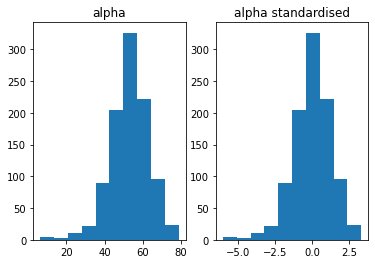

In [10]:
if __name__ == "__main__":
    dataset = QM9("datasets", "alpha", 2.0, "train", 6, feature_type="one_hot")
    print("length", len(dataset))
    ys = np.array([data.y.item() for data in dataset])
    mean, mad = dataset.calc_stats()

    for item in dataset:
        print(item.edge_index)
        break

    print("mean", mean, "mad", mad)
    import matplotlib.pyplot as plt

    plt.subplot(121)
    plt.title(dataset.target)
    plt.hist(ys)
    plt.subplot(122)
    plt.title(dataset.target + " standardised")
    plt.hist((ys - mean)/mad)
    plt.show()

In [11]:
dataset
print(dataset)

QM9(1000)


In [12]:
dataset.data

Data(x=[13170, 5], edge_index=[2, 34390], edge_attr=[34390, 49], y=[1000, 19], pos=[13170, 3], node_attr=[13170, 49], additional_message_features=[34390, 1], name=[1000], index=[1000])

In [13]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[5, 5], edge_index=[2, 20], edge_attr=[20, 49], y=13.210000038146973, pos=[5, 3], node_attr=[5, 49], additional_message_features=[20, 1], name='gdb_1', index=[1])
Number of nodes: 5
Number of edges: 20
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


### Load training data

In [14]:
import math
import torch.distributed as dist
from torch.utils.data import Sampler
import os
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data.distributed import DistributedSampler

In [15]:
def make_dataloader(dataset, batch_size, num_workers, world_size = None, rank=None, train=True):
    """ Create (disributed) dataloader """

    if world_size is not None and world_size > 1:
        if train:
            sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank)
        else:
            sampler = DistributedEvalSampler(dataset, num_replicas=world_size, rank=rank)

        parallel_batch_size = int(batch_size/world_size)
        dataloader = DataLoader(dataset, batch_size=parallel_batch_size, shuffle=(sampler is None),
                                sampler=sampler, num_workers=num_workers)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=num_workers)

    return dataloader

length 1000
tensor([[1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]])
mean 53.01295995569229 mad 7.7115207515048985


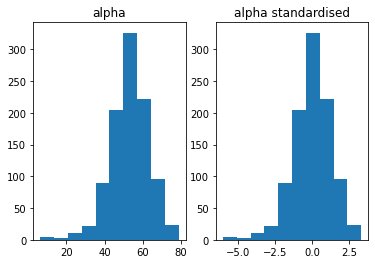

In [16]:
train_dataset = QM9(root, target, radius, "train", lmax_attr, feature_type)
print("length", len(train_dataset))
ys = np.array([data.y.item() for data in train_dataset])
mean, mad = train_dataset.calc_stats()

for item in train_dataset:
    print(item.edge_index)
    break

print("mean", mean, "mad", mad)
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title(train_dataset.target)
plt.hist(ys)
plt.subplot(122)
plt.title(train_dataset.target + " standardised")
plt.hist((ys - mean)/mad)
plt.show()

In [17]:
train_loader = make_dataloader(train_dataset, batch_size, num_workers)

length 178
tensor([[1, 0, 2, 1, 3, 2],
        [0, 1, 1, 2, 2, 3]])
mean 52.574157393380496 mad 7.075225616010086


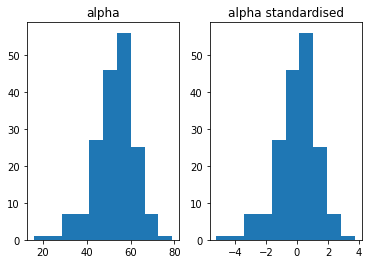

In [18]:
valid_dataset = QM9(root, target, radius, "valid", lmax_attr, feature_type)
print("length", len(valid_dataset))
ys = np.array([data.y.item() for data in valid_dataset])
mean, mad = valid_dataset.calc_stats()

for item in valid_dataset:
    print(item.edge_index)
    break

print("mean", mean, "mad", mad)
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title(valid_dataset.target)
plt.hist(ys)
plt.subplot(122)
plt.title(valid_dataset.target + " standardised")
plt.hist((ys - mean)/mad)
plt.show()

In [19]:
valid_loader = make_dataloader(valid_dataset, batch_size, num_workers, train=False )

length 130
tensor([[1, 3, 4, 0, 2, 5, 1, 0, 4, 0, 3, 1],
        [0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 5]])
mean 53.46969212752122 mad 7.9366248969354585


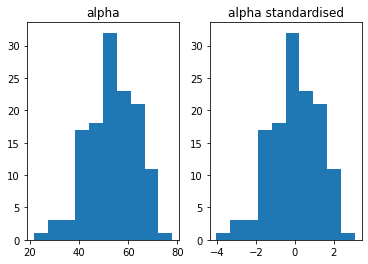

In [20]:
test_dataset = QM9(root, target, radius, "test", lmax_attr, feature_type)
print("length", len(test_dataset))
ys = np.array([data.y.item() for data in test_dataset])
mean, mad = test_dataset.calc_stats()

for item in test_dataset:
    print(item.edge_index)
    break

print("mean", mean, "mad", mad)
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title(test_dataset.target)
plt.hist(ys)
plt.subplot(122)
plt.title(test_dataset.target + " standardised")
plt.hist((ys - mean)/mad)
plt.show()

In [21]:
test_loader = make_dataloader(test_dataset, batch_size, num_workers, train=False )

In [22]:
# Get train set statistics
target_mean, target_mad = train_loader.dataset.calc_stats()

### Set the group representations

In [23]:
from e3nn.o3 import Irreps, spherical_harmonics
input_irreps = Irreps("5x0e")

In [98]:
output_irreps = Irreps("1x0e")

In [99]:
edge_attr_irreps = Irreps.spherical_harmonics(3)
node_attr_irreps = Irreps.spherical_harmonics(3)
additional_message_irreps = Irreps("1x0e")

### Create hidden irreps

In [100]:
from e3nn.o3 import Irreps
from e3nn.o3 import Linear, spherical_harmonics, FullyConnectedTensorProduct


def BalancedIrreps(lmax, vec_dim, sh_type=True):
    """ Allocates irreps equally along channel budget, resulting
        in unequal numbers of irreps in ratios of 2l_i + 1 to 2l_j + 1.
    Parameters
    ----------
    lmax : int
        Maximum order of irreps.
    vec_dim : int
        Dim of feature vector.
    sh_type : bool
        if true, use spherical harmonics. Else the full set of irreps (with redundance).
    Returns
    -------
    Irreps
        Resulting irreps for feature vectors.
    """
    irrep_spec = "0e"
    for l in range(1, lmax + 1):
        if sh_type:
            irrep_spec += " + {0}".format(l) + ('e' if (l % 2) == 0 else 'o')
        else:
            irrep_spec += " + {0}e + {0}o".format(l)
    irrep_spec_split = irrep_spec.split(" + ")
    dims = [int(irrep[0]) * 2 + 1 for irrep in irrep_spec_split]
    # Compute ratios
    ratios = [1 / dim for dim in dims]
    # Determine how many copies per irrep
    irrep_copies = [int(vec_dim * r / len(ratios)) for r in ratios]
    # Determine the current effective irrep sizes
    irrep_dims = [n * dim for (n, dim) in zip(irrep_copies, dims)]
    # Add trivial irreps until the desired size is reached
    irrep_copies[0] += vec_dim - sum(irrep_dims)

    # Convert to string
    str_out = ''
    for (spec, dim) in zip(irrep_spec_split, irrep_copies):
        str_out += str(dim) + 'x' + spec
        str_out += ' + '
    str_out = str_out[:-3]
    # Generate the irrep
    return Irreps(str_out)


def WeightBalancedIrreps(irreps_in1_scalar, irreps_in2, sh=True, lmax=None):
    """Determines an irreps_in1 type of order irreps_in2.lmax that when used in a tensor product
    irreps_in1 x irreps_in2 -> irreps_in1
    would have the same number of weights as for a standard linear layer, e.g. a tensor product
    irreps_in1_scalar x "1x0e" -> irreps_in1_scalar
    Parameters
    ----------
    irreps_in1_scalar : o3.Irreps
        Number of hidden features, represented by zeroth order irreps.
    irreps_in2 : o3.Irreps
        Irreps related to edge attributes.
    sh : bool
        if true, yields equal number of every order. Else returns balanced irrep.
    lmax : int
        Maximum order irreps to be considered.
    Returns
    -------
    o3.Irreps
        Irreps for hidden feaure vectors.
    """

    n = 1
    if lmax == None:
        lmax = irreps_in2.lmax
    irreps_in1 = (Irreps.spherical_harmonics(lmax) * n).sort().irreps.simplify() if sh else BalancedIrreps(lmax, n)
    weight_numel1 = FullyConnectedTensorProduct(irreps_in1, irreps_in2, irreps_in1).weight_numel
    weight_numel_scalar = FullyConnectedTensorProduct(irreps_in1_scalar, Irreps("1x0e"), irreps_in1_scalar).weight_numel
    while weight_numel1 < weight_numel_scalar:  # TODO: somewhat suboptimal implementation...
        n += 1
        irreps_in1 = (Irreps.spherical_harmonics(lmax) * n).sort().irreps.simplify() if sh else BalancedIrreps(lmax, n)
        weight_numel1 = FullyConnectedTensorProduct(irreps_in1, irreps_in2, irreps_in1).weight_numel
    print('Determined irrep type:', irreps_in1)
    return Irreps(irreps_in1)

In [101]:
hidden_irreps = WeightBalancedIrreps(
            Irreps("{}x0e".format(hidden_features)), node_attr_irreps, sh=True, lmax=lmax_h)

Determined irrep type: 9x0e+9x1o+9x2e


### SEGNN Model Build

In [102]:

import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing, global_mean_pool, global_add_pool
from e3nn.nn import BatchNorm, Gate
from e3nn.o3 import Irreps, Linear, spherical_harmonics, FullyConnectedTensorProduct
import numpy as np
from math import sqrt

In [103]:
class O3TensorProduct(nn.Module):
    """ A bilinear layer, computing CG tensorproduct and normalising them.
    Parameters
    ----------
    irreps_in1 : o3.Irreps
        Input irreps.
    irreps_out : o3.Irreps
        Output irreps.
    irreps_in2 : o3.Irreps
        Second input irreps.
    tp_rescale : bool
        If true, rescales the tensor product.
    """

    def __init__(self, irreps_in1, irreps_out, irreps_in2=None, tp_rescale=True) -> None:
        super().__init__()

        self.irreps_in1 = irreps_in1
        self.irreps_out = irreps_out
        # Init irreps_in2
        if irreps_in2 == None:
            self.irreps_in2_provided = False
            self.irreps_in2 = Irreps("1x0e")
        else:
            self.irreps_in2_provided = True
            self.irreps_in2 = irreps_in2
        self.tp_rescale = tp_rescale

        # Build the layers
        self.tp = FullyConnectedTensorProduct(
            irreps_in1=self.irreps_in1,
            irreps_in2=self.irreps_in2,
            irreps_out=self.irreps_out, shared_weights=True, normalization='component')

        # For each zeroth order output irrep we need a bias
        # So first determine the order for each output tensor and their dims
        self.irreps_out_orders = [int(irrep_str[-2]) for irrep_str in str(irreps_out).split('+')]
        self.irreps_out_dims = [int(irrep_str.split('x')[0]) for irrep_str in str(irreps_out).split('+')]
        self.irreps_out_slices = irreps_out.slices()
        # Store tuples of slices and corresponding biases in a list
        self.biases = []
        self.biases_slices = []
        self.biases_slice_idx = []
        for slice_idx in range(len(self.irreps_out_orders)):
            if self.irreps_out_orders[slice_idx] == 0:
                out_slice = irreps_out.slices()[slice_idx]
                out_bias = torch.zeros(self.irreps_out_dims[slice_idx], dtype=self.tp.weight.dtype)
                self.biases += [out_bias]
                self.biases_slices += [out_slice]
                self.biases_slice_idx += [slice_idx]

        # Initialize the correction factors
        self.slices_sqrt_k = {}

        # Initialize similar to the torch.nn.Linear
        self.tensor_product_init()
        # Adapt parameters so they can be applied using vector operations.
        self.vectorise()

    def tensor_product_init(self) -> None:
        with torch.no_grad():
            # Determine fan_in for each slice, it could be that each output slice is updated via several instructions
            slices_fan_in = {}  # fan_in per slice
            for weight, instr in zip(self.tp.weight_views(), self.tp.instructions):
                slice_idx = instr[2]
                mul_1, mul_2, mul_out = weight.shape
                fan_in = mul_1 * mul_2
                slices_fan_in[slice_idx] = (slices_fan_in[slice_idx] +
                                            fan_in if slice_idx in slices_fan_in.keys() else fan_in)
            # Do the initialization of the weights in each instruction
            for weight, instr in zip(self.tp.weight_views(), self.tp.instructions):
                # The tensor product in e3nn already normalizes proportional to 1 / sqrt(fan_in), and the weights are by
                # default initialized with unif(-1,1). However, we want to be consistent with torch.nn.Linear and
                # initialize the weights with unif(-sqrt(k),sqrt(k)), with k = 1 / fan_in
                slice_idx = instr[2]
                if self.tp_rescale:
                    sqrt_k = 1 / sqrt(slices_fan_in[slice_idx])
                else:
                    sqrt_k = 1.
                weight.data.uniform_(-sqrt_k, sqrt_k)
                self.slices_sqrt_k[slice_idx] = (self.irreps_out_slices[slice_idx], sqrt_k)

            # Initialize the biases
            for (out_slice_idx, out_slice, out_bias) in zip(self.biases_slice_idx, self.biases_slices, self.biases):
                sqrt_k = 1 / sqrt(slices_fan_in[out_slice_idx])
                out_bias.uniform_(-sqrt_k, sqrt_k)

    def vectorise(self):
        """ Adapts the bias parameter and the sqrt_k corrections so they can be applied using vectorised operations """

        # Vectorise the bias parameters
        if len(self.biases) > 0:
            with torch.no_grad():
                self.biases = torch.cat(self.biases, dim=0)
            self.biases = nn.Parameter(self.biases)

            # Compute broadcast indices.
            bias_idx = torch.LongTensor()
            for slice_idx in range(len(self.irreps_out_orders)):
                if self.irreps_out_orders[slice_idx] == 0:
                    out_slice = self.irreps_out.slices()[slice_idx]
                    bias_idx = torch.cat((bias_idx, torch.arange(out_slice.start, out_slice.stop).long()), dim=0)

            self.register_buffer("bias_idx", bias_idx, persistent=False)
        else:
            self.biases = None

        # Now onto the sqrt_k correction
        sqrt_k_correction = torch.zeros(self.irreps_out.dim)
        for instr in self.tp.instructions:
            slice_idx = instr[2]
            slice, sqrt_k = self.slices_sqrt_k[slice_idx]
            sqrt_k_correction[slice] = sqrt_k

        # Make sure bias_idx and sqrt_k_correction are on same device as module
        self.register_buffer("sqrt_k_correction", sqrt_k_correction, persistent=False)

    def forward_tp_rescale_bias(self, data_in1, data_in2=None) -> torch.Tensor:
        if data_in2 == None:
            data_in2 = torch.ones_like(data_in1[:, 0:1])

        data_out = self.tp(data_in1, data_in2)

        # Apply corrections
        if self.tp_rescale:
            data_out /= self.sqrt_k_correction

        # Add the biases
        if self.biases is not None:
            data_out[:, self.bias_idx] += self.biases
        return data_out

    def forward(self, data_in1, data_in2=None) -> torch.Tensor:
        # Apply the tensor product, the rescaling and the bias
        data_out = self.forward_tp_rescale_bias(data_in1, data_in2)
        return data_out

In [104]:
class O3TensorProductSwishGate(O3TensorProduct):
    def __init__(self, irreps_in1, irreps_out, irreps_in2=None) -> None:
        # For the gate the output of the linear needs to have an extra number of scalar irreps equal to the amount of
        # non scalar irreps:
        # The first type is assumed to be scalar and passed through the activation
        irreps_g_scalars = Irreps(str(irreps_out[0]))
        # The remaining types are gated
        irreps_g_gate = Irreps("{}x0e".format(irreps_out.num_irreps - irreps_g_scalars.num_irreps))
        irreps_g_gated = Irreps(str(irreps_out[1:]))
        # So the gate needs the following irrep as input, this is the output irrep of the tensor product
        irreps_g = (irreps_g_scalars + irreps_g_gate + irreps_g_gated).simplify()

        # Build the layers
        super(O3TensorProductSwishGate, self).__init__(irreps_in1, irreps_g, irreps_in2)
        if irreps_g_gated.num_irreps > 0:
            self.gate = Gate(irreps_g_scalars, [nn.SiLU()], irreps_g_gate, [torch.sigmoid], irreps_g_gated)
        else:
            self.gate = nn.SiLU()

    def forward(self, data_in1, data_in2=None) -> torch.Tensor:
        # Apply the tensor product, the rescaling and the bias
        data_out = self.forward_tp_rescale_bias(data_in1, data_in2)
        # Apply the gate
        data_out = self.gate(data_out)
        # Return result
        return data_out

In [105]:
class O3SwishGate(torch.nn.Module):
    def __init__(self, irreps_g_scalars, irreps_g_gate, irreps_g_gated) -> None:
        super().__init__()
        if irreps_g_gated.num_irreps > 0:
            self.gate = Gate(irreps_g_scalars, [nn.SiLU()], irreps_g_gate, [torch.sigmoid], irreps_g_gated)
        else:
            self.gate = nn.SiLU()

    def forward(self, data_in) -> torch.Tensor:
        data_out = self.gate(data_in)
        return data_out

The purpose of Instance Normalization is to normalize each feature vector in the input tensor by its norm, which is invariant under orthonormal representations. The normalization is applied separately to each batch element and feature vector. In addition to normalization, Instance Normalization can also apply an affine transformation to each feature vector, consisting of a learned weight and bias parameter.

In [106]:
class InstanceNorm(nn.Module):
    '''Instance normalization for orthonormal representations
    It normalizes by the norm of the representations.
    Note that the norm is invariant only for orthonormal representations.
    Irreducible representations `wigner_D` are orthonormal.
    Parameters
    ----------
    irreps : `Irreps`
        representation
    eps : float
        avoid division by zero when we normalize by the variance
    affine : bool
        do we have weight and bias parameters
    reduce : {'mean', 'max'}
        method used to reduce
    '''

    def __init__(self, irreps, eps=1e-5, affine=True, reduce='mean', normalization='component'):
        super().__init__()

        self.irreps = Irreps(irreps)
        self.eps = eps
        self.affine = affine

        num_scalar = sum(mul for mul, ir in self.irreps if ir.l == 0)
        num_features = self.irreps.num_irreps

        if affine:
            self.weight = nn.Parameter(torch.ones(num_features))
            self.bias = nn.Parameter(torch.zeros(num_scalar))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

        assert isinstance(reduce, str), "reduce should be passed as a string value"
        assert reduce in ['mean', 'max'], "reduce needs to be 'mean' or 'max'"
        self.reduce = reduce

        assert normalization in ['norm', 'component'], "normalization needs to be 'norm' or 'component'"
        self.normalization = normalization

    def __repr__(self):
        return f"{self.__class__.__name__} ({self.irreps}, eps={self.eps})"

    def forward(self, input, batch):
        '''evaluate
        Parameters
        ----------
        input : `torch.Tensor`
            tensor of shape ``(batch, ..., irreps.dim)``
        Returns
        -------
        `torch.Tensor`
            tensor of shape ``(batch, ..., irreps.dim)``
        '''
        # batch, *size, dim = input.shape  # TODO: deal with batch
        # input = input.reshape(batch, -1, dim)  # [batch, sample, stacked features]
        # input has shape [batch * nodes, dim], but with variable nr of nodes.
        # the input batch slices this into separate graphs
        dim = input.shape[-1]

        fields = []
        ix = 0
        iw = 0
        ib = 0

        for mul, ir in self.irreps:  # mul is the multiplicity (number of copies) of some irrep type (ir)
            d = ir.dim
            field = input[:, ix: ix + mul * d]  # [batch * sample, mul * repr]
            ix += mul * d

            # [batch * sample, mul, repr]
            field = field.reshape(-1, mul, d)

            # For scalars first compute and subtract the mean
            if ir.l == 0:
                # Compute the mean
                field_mean = global_mean_pool(field, batch).reshape(-1, mul, 1)  # [batch, mul, 1]]
                # Subtract the mean
                field = field - field_mean[batch]

            # Then compute the rescaling factor (norm of each feature vector)
            # Rescaling of the norms themselves based on the option "normalization"
            if self.normalization == 'norm':
                field_norm = field.pow(2).sum(-1)  # [batch * sample, mul]
            elif self.normalization == 'component':
                field_norm = field.pow(2).mean(-1)  # [batch * sample, mul]
            else:
                raise ValueError("Invalid normalization option {}".format(self.normalization))
            # Reduction method
            if self.reduce == 'mean':
                field_norm = global_mean_pool(field_norm, batch)  # [batch, mul]
            elif self.reduce == 'max':
                field_norm = global_max_pool(field_norm, batch)  # [batch, mul]
            else:
                raise ValueError("Invalid reduce option {}".format(self.reduce))

            # Then apply the rescaling (divide by the sqrt of the squared_norm, i.e., divide by the norm
            field_norm = (field_norm + self.eps).pow(-0.5)  # [batch, mul]

            if self.affine:
                weight = self.weight[None, iw: iw + mul]  # [batch, mul]
                iw += mul
                field_norm = field_norm * weight  # [batch, mul]

            field = field * field_norm[batch].reshape(-1, mul, 1)  # [batch * sample, mul, repr]

            if self.affine and d == 1:  # scalars
                bias = self.bias[ib: ib + mul]  # [batch, mul]
                ib += mul
                field += bias.reshape(mul, 1)  # [batch * sample, mul, repr]

            # Save the result, to be stacked later with the rest
            fields.append(field.reshape(-1, mul * d))  # [batch * sample, mul * repr]

        if ix != dim:
            fmt = "`ix` should have reached input.size(-1) ({}), but it ended at {}"
            msg = fmt.format(dim, ix)
            raise AssertionError(msg)

        output = torch.cat(fields, dim=-1)  # [batch * sample, stacked features]
        return output

## SEGNN Implementation

### Message Passing layer

The constructor initializes several layers for message passing and node updates. Specifically, it initializes two O3TensorProductSwishGate layers for computing messages, and two O3TensorProduct layers for updating node features. It also sets up normalisation, either batch or instance norm.

The forward method takes node features, edge indices, edge features, node attributes, batch indices, and additional message features as input, and propagates messages along edges using the propagate method of MessagePassing. It then applies normalisation to the resulting node features.

The message method computes messages using the message_layer_1 and message_layer_2 layers, and applies normalisation to the resulting messages. It takes input node features of sender and receiver nodes, edge attributes, and additional message features as input.

The update method updates node features using the update_layer_1 and update_layer_2 layers, and adds a residual connection to the original node features. It takes messages, node features, and node attributes as input, and returns updated node features.

In [107]:
class SEGNNLayer(MessagePassing):
    """E(3) equivariant message passing layer."""

    def __init__(
        self,
        input_irreps,
        hidden_irreps,
        output_irreps,
        edge_attr_irreps,
        node_attr_irreps,
        norm=None,
        additional_message_irreps=None,
    ):
        super().__init__(node_dim=-2, aggr="add")
        self.hidden_irreps = hidden_irreps

        message_input_irreps = (2 * input_irreps + additional_message_irreps).simplify()
        update_input_irreps = (input_irreps + hidden_irreps).simplify()

        self.message_layer_1 = O3TensorProductSwishGate(
            message_input_irreps, hidden_irreps, edge_attr_irreps
        )
        self.message_layer_2 = O3TensorProductSwishGate(
            hidden_irreps, hidden_irreps, edge_attr_irreps
        )
        self.update_layer_1 = O3TensorProductSwishGate(
            update_input_irreps, hidden_irreps, node_attr_irreps
        )
        self.update_layer_2 = O3TensorProduct(
            hidden_irreps, hidden_irreps, node_attr_irreps
        )

        self.setup_normalisation(norm)

    def setup_normalisation(self, norm):
        """Set up normalisation, either batch or instance norm"""
        self.norm = norm
        self.feature_norm = None
        self.message_norm = None

        if norm == "batch":
            self.feature_norm = BatchNorm(self.hidden_irreps)
            self.message_norm = BatchNorm(self.hidden_irreps)
        elif norm == "instance":
            self.feature_norm = InstanceNorm(self.hidden_irreps)

        self.feature_norm = InstanceNorm(self.hidden_irreps)

    def forward(
        self,
        x,
        edge_index,
        edge_attr,
        node_attr,
        batch,
        additional_message_features=None,
    ):
        """Propagate messages along edges"""
        x = self.propagate(
            edge_index,
            x=x,
            node_attr=node_attr,
            edge_attr=edge_attr,
            additional_message_features=additional_message_features,
        )
        # Normalise features
        if self.feature_norm:
            if self.norm == "batch":
                x = self.feature_norm(x)
            elif self.norm == "instance":
                x = self.feature_norm(x, batch)
            x = self.feature_norm(x, batch)
        return x

    def message(self, x_i, x_j, edge_attr, additional_message_features):
        """Create messages"""
        if additional_message_features is None:
            input = torch.cat((x_i, x_j), dim=-1)
        else:
            input = torch.cat((x_i, x_j, additional_message_features), dim=-1)

        message = self.message_layer_1(input, edge_attr)
        message = self.message_layer_2(message, edge_attr)

        if self.message_norm:
            message = self.message_norm(message)
        return message

    def update(self, message, x, node_attr):
        """Update note features"""
        input = torch.cat((x, message), dim=-1)
        update = self.update_layer_1(input, node_attr)
        update = self.update_layer_2(update, node_attr)
        x += update  # Residual connection
        return x

### Steerable modules

The `__init__` method initializes the neural network's architecture, which consists of an embedding layer, several message passing layers, and output layers. The `forward` method performs the forward pass of the neural network on a graph object.

During the forward pass, the graph object's features are first embedded using the `embedding_layer`. The resulting node features are then passed through the layers, which perform message passing between nodes. The output from the message passing layers is then processed by the `pre_pool1` and `pre_pool2` layers to prepare it for pooling.

The pooling method is determined by the pool argument passed to the SEGNN constructor. Currently, the module supports average and sum pooling. If the output task is graph-level, the pooled output is passed through the `post_pool1` and `post_pool2` layers to produce the final output. If the output task is node-level, the pooled output is passed through the `pre_pool2` layer to produce the final output.

The `catch_isolated_nodes` method is used to handle isolated nodes in the input graph, which should still receive node attributes. If the input graph contains isolated nodes, new attributes are added to the graph object to ensure that every node has an attribute.

In [127]:
from torch_geometric.nn import TransformerConv, global_mean_pool

class SEGNN(nn.Module):
    """Steerable E(3) equivariant message passing network"""

    def __init__(
        self,
        input_irreps,
        hidden_irreps,
        output_irreps,
        edge_attr_irreps,
        node_attr_irreps,
        num_layers,
        norm=None,
        pool="avg",
        task="graph",
        additional_message_irreps=None,
    ):
        super().__init__()
        self.task = task
        self.embedding_layer = O3TensorProduct(
            input_irreps, hidden_irreps, node_attr_irreps
        )

        # Message passing layers.
        segnn_layers = []
        for i in range(num_layers):
            segnn_layers.append(
                SEGNNLayer(
                    hidden_irreps,
                    hidden_irreps,
                    hidden_irreps,
                    edge_attr_irreps,
                    node_attr_irreps,
                    norm=norm,
                    additional_message_irreps=additional_message_irreps,
                )
            )
        self.segnn_layers = nn.ModuleList(segnn_layers)

        # TransformerConv layers.
        transformer_layers = []
        for i in range(num_layers):
            transformer_layers.append(
                TransformerConv(
                    hidden_irreps.num_irreps,
                    hidden_irreps.num_irreps,
                    8,
                    edge_attr_irreps.dim(),
                    node_attr_irreps.dim(),
                )
            )
        self.transformer_layers = nn.ModuleList(transformer_layers)

        # Prepare for output irreps, since the attrs will disappear after pooling
        if task == "graph":
            pooled_irreps = (
                (output_irreps * hidden_irreps.num_irreps).simplify().sort().irreps
            )
            self.pre_pool1 = O3TensorProductSwishGate(
                hidden_irreps, hidden_irreps, node_attr_irreps
            )
            self.pre_pool2 = O3TensorProduct(
                hidden_irreps, pooled_irreps, node_attr_irreps
            )
            self.post_pool1 = O3TensorProductSwishGate(pooled_irreps, pooled_irreps)
            self.post_pool2 = O3TensorProduct(pooled_irreps, output_irreps)
            self.init_pooler(pool)
        elif task == "node":
            self.pre_pool1 = O3TensorProductSwishGate(
                hidden_irreps, hidden_irreps, node_attr_irreps
            )
            self.pre_pool2 = O3TensorProduct(
                hidden_irreps, output_irreps, node_attr_irreps
            )

    def init_pooler(self, pool):
        """Initialise pooling mechanism"""
        if pool == "avg":
            self.pooler = global_mean_pool
        elif pool == "sum":
            self.pooler = global_add_pool

    def catch_isolated_nodes(self, graph):
        """Isolated nodes should also obtain attributes"""
        if (
            graph.contains_isolated_nodes()
            and graph.edge_index.max().item() + 1 != graph.num_nodes
        ):
            nr_add_attr = graph.num_nodes - (graph.edge_index.max().item() + 1)
            add_attr = graph.node_attr.new_tensor(
                np.zeros((nr_add_attr, node_attr.shape[-1]))
            )
            graph.node_attr = torch.cat((graph.node_attr, add_attr), -2)
        # Trivial irrep value should always be 1 (is automatically so for connected nodes, but isolated nodes are now 0)
        graph.node_attr[:, 0] = 1.0

    def forward(self, graph):
        """SEGNN forward pass"""
        x, pos, edge_index, edge_attr, node_attr, batch = (
            graph.x,
            graph.pos,
            graph.edge_index,
            graph.edge_attr,
            graph.node_attr,
            graph.batch,
        )
        try:
            additional_message_features = graph.additional_message_features
        except AttributeError:
            additional_message_features = None

        self.catch_isolated_nodes(graph)

        # Embed
        x = self.embedding_layer(x, node_attr)

        # Pass messages using SEGNN layers
        segnn_output = x
        for layer in self.segnn_layers:
            segnn_output = layer(
                segnn_output, edge_index, edge_attr, node_attr, batch, additional_message_features
            )

        # Pass messages using TransformerConv layers
        transformer_output = x
        for layer in self.transformer_layers:
            transformer_output = layer(transformer_output, edge_index)

        # Combine SEGNN and TransformerConv outputs
        x = segnn_output + transformer_output

        # Pre pool
        x = self.pre_pool1(x, node_attr)
        x = self.pre_pool2(x, node_attr)

        if self.task == "graph":
            # Pool over nodes
            x = self.pooler(x, batch)

            # Predict
            x = self.post_pool1(x)
            x = self.post_pool2(x)
        return x

In [128]:
model = SEGNN(input_irreps,
              hidden_irreps,
              output_irreps,
              edge_attr_irreps,
              node_attr_irreps,
              num_layers=layers,
              norm=norm,
              pool=pool,
              task=task,
              additional_message_irreps=additional_message_irreps)

TypeError: 'int' object is not callable

In [115]:
print(type(dataset))

<class '__main__.QM9'>


In [116]:
ID = "_".join(["segnn", str(dataset), target, str(np.random.randint(1e4, 1e5))])


In [117]:
ID

'segnn_QM9(1000)_alpha_61596'

In [119]:
print(model)


SEGNN(
  (embedding_layer): O3TensorProduct(
    (tp): FullyConnectedTensorProduct(5x0e x 1x0e+1x1o+1x2e+1x3o -> 9x0e+9x1o+9x2e | 135 paths | 135 weights)
  )
  (segnn_layers): ModuleList(
    (0): SEGNNLayer()
    (1): SEGNNLayer()
    (2): SEGNNLayer()
  )
  (transformer_layers): ModuleList(
    (0): TransformerConv(27, 27, heads=8)
    (1): TransformerConv(27, 27, heads=8)
    (2): TransformerConv(27, 27, heads=8)
  )
  (pre_pool1): O3TensorProductSwishGate(
    (tp): FullyConnectedTensorProduct(9x0e+9x1o+9x2e x 1x0e+1x1o+1x2e+1x3o -> 27x0e+9x1o+9x2e | 1539 paths | 1539 weights)
    (gate): Gate (27x0e+9x1o+9x2e -> 9x0e+9x1o+9x2e)
  )
  (pre_pool2): O3TensorProduct(
    (tp): FullyConnectedTensorProduct(9x0e+9x1o+9x2e x 1x0e+1x1o+1x2e+1x3o -> 27x0e | 729 paths | 729 weights)
  )
  (post_pool1): O3TensorProductSwishGate(
    (tp): FullyConnectedTensorProduct(27x0e x 1x0e -> 27x0e | 729 paths | 729 weights)
    (gate): SiLU()
  )
  (post_pool2): O3TensorProduct(
    (tp): FullyConnect

In [120]:
print("The model has {:,} parameters.".format(sum(p.numel() for p in model.parameters())))

The model has 104,527 parameters.


## Training

In [121]:
import wandb
import numpy as np
import os
import torch
import torch.nn as nn
import torch.distributed as dist
from torch.optim.lr_scheduler import MultiStepLR

First let's define evaluation function.

In here, the `N` tensor will be used to keep track of the total number of samples in the dataloader, and `score` tensor will be used to keep track of the sum of the losses computed for each sample.

In [122]:
def evaluate(model, dataloader, criterion, device, loc=0, scale=1):
    """ Evaluate a model on the dataloader, with distributed communication (if necessary) """
    model.eval()
    N = torch.zeros(1).to(device)
    score = torch.zeros(1).to(device)

    with torch.no_grad():  #ensure that the computation graph is not built, which saves memory and speeds up the process. 
        for graph in dataloader:
            graph = graph.to(device)
            out = model(graph).squeeze()

            n = graph.y.size(0)
            N += n
            score += n*criterion(out*scale + loc, graph.y)

    model.train()
    # if world_size > 1:
    #     dist.all_reduce(score)
    #     dist.all_reduce(N)

    return (score/N).item()

In [123]:
import os
def save_model(model, dir, id, gpu=""):
    """ Save a model """
    os.makedirs(dir, exist_ok=True)
    if gpu != "":
        gpu = "_" + str(gpu)

    torch.save(model.state_dict(), os.path.join(dir, id + gpu + ".pt"))

In [124]:
def load_model(model, dir, id, gpu=""):
    """ Load a state dict into a model """
    if gpu != "":
        gpu = "_" + str(gpu)
    state_dict = torch.load(os.path.join(dir, id + gpu + ".pt"))
    model.load_state_dict(state_dict)
    return model

Now let's define training function.

The function first creates dataloaders for the training, validation, and test sets using the make_dataloader() function. It also calculates the mean and MAD (median absolute deviation) of the target variable in the training set.

The optimizer and learning rate scheduler are set up next, followed by the loss function (in this case, L1 loss). The function then initializes the logging and wandb parameters (if logging is enabled) and starts the training loop.

For each epoch, the function loops through the training set and trains the model using the optimizer and loss function. The function also logs training statistics and evaluates the model on the validation set after each epoch. The learning rate is adjusted using the scheduler.

Finally, the function evaluates the model on the test set and logs the test MAE. If logging is enabled, the function saves the trained model to disk and finishes the logging. 

In [125]:
print_variable=100
lr = 5e-4 #learning rate
weight_decay=1e-8
def train(gpu, model):
    
    device = 'cuda:' + str(gpu)
    
    model = model.to(device)

    # Create datasets and dataloaders
    # train_loader = utils.make_dataloader(QM9(args.root, args.target, args.radius, "train", args.lmax_attr,
    #                                          feature_type=args.feature_type), args.batch_size, args.num_workers, args.gpus, gpu)
    # valid_loader = utils.make_dataloader(QM9(args.root, args.target, args.radius, "valid", args.lmax_attr,
    #                                          feature_type=args.feature_type), args.batch_size, args.num_workers, args.gpus, gpu, train=False)
    # test_loader = utils.make_dataloader(QM9(args.root, args.target, args.radius, "test", args.lmax_attr,
    #                                         feature_type=args.feature_type), args.batch_size, args.num_workers, args.gpus, gpu, train=False)

    # Get train set statistics
    target_mean, target_mad = train_loader.dataset.calc_stats()

    # Set up optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = MultiStepLR(optimizer, milestones=[int(0.8*(epochs)), int(0.9*(epochs))], verbose=True)
    criterion = nn.L1Loss()

    # Logging parameters
    # target = args.target
    best_valid_MAE = 1e30
    i = 0
    N_samples = 0
    loss_sum = 0
    train_MAE_sum = 0

    # # Init wandb
    # if log and gpu == 0:
    #     wandb.init(project="SEGNN " + str(dataset) + " " + target, name=ID, entity="segnn")

    # Let's start!
    # if gpu == 0:
    print("Training:", ID)
    for epoch in range(epochs):
        # # Set epoch so shuffling works right in distributed mode.
        # if args.gpus > 1:
        #     train_loader.sampler.set_epoch(epoch)
        # Training loop

        for step, graph in enumerate(train_loader):
            # Forward & Backward.
            graph = graph.to(device)
            out = model(graph).squeeze()
            loss = criterion(out, (graph.y - target_mean)/target_mad)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            i += 1
            N_samples += graph.y.size(0)
            loss_sum += loss
            train_MAE_sum += criterion(out.detach()*target_mad + target_mean, graph.y)*graph.y.size(0)

            # Report
            if i % print_variable == 0:
                print("epoch:%2d  step:%4d  loss: %0.4f  train MAE:%0.4f" %
                      (epoch, step, loss_sum/i, train_MAE_sum/N_samples))

                # if log and gpu == 0:
                #     wandb.log({"loss": loss_sum/i, target + " train MAE": train_MAE_sum /
                #                N_samples})

                i = 0
                N_samples = 0
                loss_sum = 0
                train_MAE_sum = 0

        # Evaluate on validation set
        valid_MAE = evaluate(model, valid_loader, criterion, device, target_mean, target_mad)
        # Save best validation model
        if valid_MAE < best_valid_MAE:
            best_valid_MAE = valid_MAE
            save_model(model, save_dir, ID, device)
        # if gpu == 0:
        print("VALIDATION: epoch:%2d  step:%4d  %s-MAE:%0.4f" %
                (epoch, step, target, valid_MAE))
            # if log:
            #     wandb.log({target + " val MAE": valid_MAE})

        # Adapt learning rate
        scheduler.step()

    # Final evaluation on test set
    model = load_model(model, save_dir, ID, device)
    test_MAE = evaluate(model, test_loader, criterion, device, target_mean, target_mad, )
    # if gpu == 0:
    print("TEST: epoch:%2d  step:%4d  %s-MAE:%0.4f" %
            (epoch, step, target, test_MAE))
    #     if log:
    #         wandb.log({target + " test MAE": test_MAE})
    #         wandb.save(os.path.join(save_dir, ID + "_" + device + ".pt"))

    # if log and gpu == 0:
    #     wandb.finish()

In [126]:
print('Starting training on a single gpu...')
mode = 'gpu'
train(0, model)

Starting training on a single gpu...
Adjusting learning rate of group 0 to 5.0000e-04.
Training: segnn_QM9(1000)_alpha_61596


/home/intern/anaconda3/envs/envname/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1690x81 and 27x216)